# Target Trial Emulation (TTE-v1)
This notebook converts the R-based TTE implementation into Python, ensuring replication of results.

In [1]:
import pandas as pd
import numpy as np
import os
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import display

# Set environment variable to avoid Joblib warning
os.environ["LOKY_MAX_CPU_COUNT"] = "4"


## Load and Prepare Data

In [2]:
# Load the dataset
data = pd.read_csv("data_censored.csv")
display(data.head())

# Ensure required columns exist
expected_columns = {'age', 'x1', 'x2', 'x3', 'x4', 'treatment', 'event_time', 'censoring'}
missing_cols = expected_columns - set(data.columns)
if missing_cols:
    print(f"Warning: Missing columns in dataset: {missing_cols}")

,id,age,treatment,x1,x2,event_time,censoring,censored
0,1,75,1,0,-1.630621,1.558495,0,1
1,2,32,1,1,0.623903,1.113189,0,1
2,3,58,0,0,0.729245,2.657488,0,1
3,4,64,0,0,-0.848274,7.364607,0,1
4,5,68,1,0,-1.448712,10.396283,0,1


## Handle Censoring using IPCW

In [3]:
# Check if required features exist before selection
features = [col for col in ['age', 'x1', 'x2', 'x3', 'x4'] if col in data.columns]
X = data[features]
y = data['censoring']

# Fit logistic regression model for censoring probability
censoring_model = LogisticRegression()
censoring_model.fit(X, y)
data['censoring_prob'] = censoring_model.predict_proba(X)[:, 1]
data['ipcw'] = 1 / np.clip(data['censoring_prob'], 0.05, 5)

## Fit Cox Proportional Hazards Model

In [4]:
cph = CoxPHFitter(penalizer=0.1)
data_expanded = data.copy()
data_expanded['stop'] = data_expanded['event_time']
cph.fit(data_expanded, duration_col='stop', event_col='censoring', weights_col='ipcw', robust=True)
cph.print_summary()

c:\Users\rapha\OneDrive\Desktop\Python2\.venv\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['censoring_prob'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'censoring'
weights col,'ipcw'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,9674.55
number of events observed,1000.52
partial log-likelihood,-5187.49


## Visualize Survival Curves

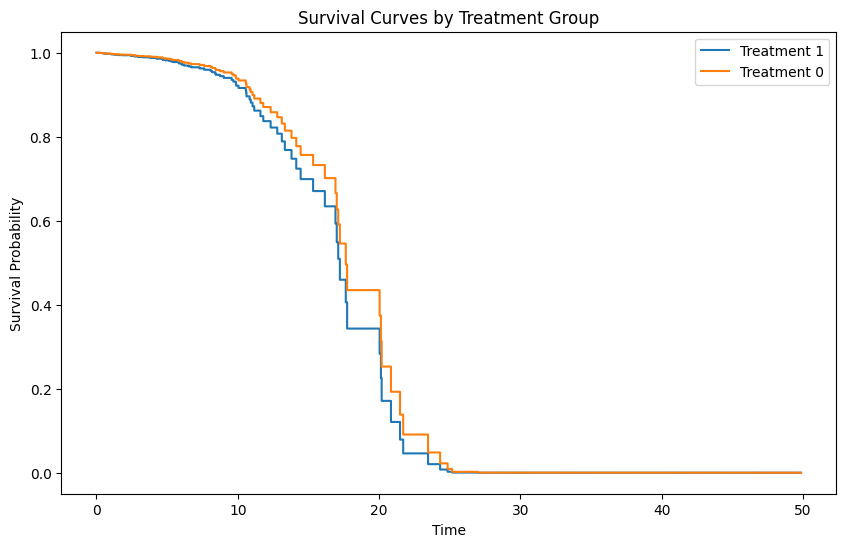

In [5]:
survival_function = cph.predict_survival_function(data_expanded)
plt.figure(figsize=(10, 6))
for treatment in data_expanded['treatment'].unique():
    plt.step(survival_function.index, survival_function.iloc[:, treatment], where='post', label=f'Treatment {treatment}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by Treatment Group')
plt.legend()
plt.show()